In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iris import irisRequests
import ngl
import datetime
from numba import njit
from numba.typed import Dict
from sklearn.metrics.pairwise import haversine_distances

In [ ]:
@njit
def construct_aftershocks_map(region, coords, dlat, dlon):
    N_lat = int((region[1]-region[0])/dlat)
    N_lon = int((region[3]-region[2])/dlon)
    shocks_map = np.zeros((N_lat, N_lon))
    for coord in coords:
        i,j = int((coord[0]-region[0])/dlat), int((coord[1]-region[2])/dlon)
        shocks_map[i,j] += 1
        #if(i>0):
        #    shocks_map[i-1,j] += 1
        #if(j>0):
        #    shocks_map[i,j-1] += 1
        #if(i < N_lat-1):
        #    shocks_map[i+1,j] += 1
        #if(j < N_lon-1):
        #    shocks_map[i,j+1] += 1
    return shocks_map

In [ ]:
rootpath = "csv_24/"

In [ ]:
regions = {}
regions['greece'] = (30, 42,18, 44)
regions['california'] = (30, 41, -125, -113)
regions['japan'] = (20, 50, 120, 150)
regions['italy'] = (35,46,6, 19)

In [ ]:
station_list = ngl.ngl_process_list(ngl.ngl_24h_2w) # daily measurements, with 2 weeks delay

In [ ]:
station_info = {}
for name, region in regions.items():
    station_names, station_lats, station_lons  = ngl.get_all_stations_box(station_list, *region)
    station_info[name]= (station_names, station_lats, station_lons)

In [ ]:
station_data = {}
for name, s_info in station_info.items():
    for s_cnt, s_name in enumerate(s_info[0]):
        df, status = ngl.ngl_retrieve_24h(rootpath, s_name)
        print(s_name, status)
        station_data[s_name] = df

In [ ]:
start_time = datetime.datetime(2012, 1, 1, 0, 0, 0)
end_time =  datetime.datetime(2024, 1, 1, 0, 0, 0)
catalogs = {}
for name, region in regions.items():
    download_url =irisRequests.url_events_box(start_time, end_time, region[0], region[1], region[2], region[3], minmag=3, magtype="MW")
    df = pd.read_csv(download_url, sep="|", comment="#", parse_dates=["Time"])
    df.sort_values(by="Time", inplace=True)
    df.reset_index(inplace=True, drop=True)
    catalogs[name] = df

In [ ]:
@njit(nogil=True)
def construct_map(u, idx, d, d_cutoff = 0.01):
    # u = (N_s, 3)
    # idx = (N_s)
    # d = (N_lat, N_lon, N_s_tot)
    u_map = np.zeros((d.shape[0], d.shape[1], 3))
    for i in range(0, d.shape[0]):
        for j in range(0, d.shape[1]):
            cnt = 0
            for i_n,n in enumerate(idx):
                d_ijn = d[i,j,n]
                if(d_ijn <= d_cutoff):
                    u_map[i,j,:] = u_map[i,j,:] + u[i_n, :]
                    cnt += 1
            if(cnt > 0):
                u_map[i,j,:] = u_map[i,j,:]/float(cnt)
            else:
                u_map[i,j,0] = np.nan
                u_map[i,j,1] = np.nan
                u_map[i,j,2] = np.nan
    return u_map


greece
2012-04-16 11:23:42+00:00


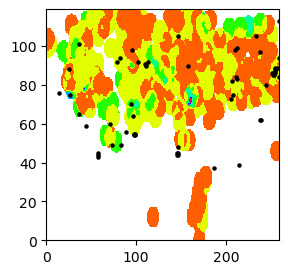

246
2012-06-10 12:44:16+00:00


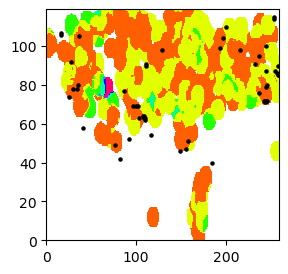

238
2012-07-09 13:55:00+00:00


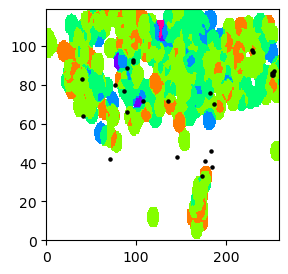

235
2013-01-08 14:16:09+00:00


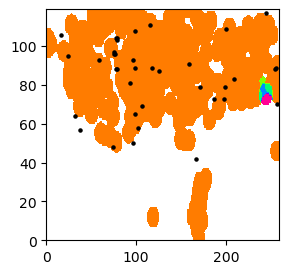

226
2013-06-15 16:11:02+00:00


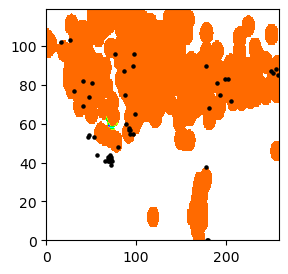

219
2013-06-16 21:39:06+00:00


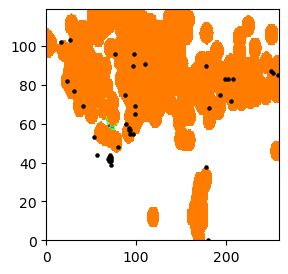

218
2013-10-12 13:11:53+00:00


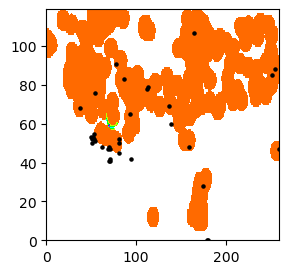

176
2013-12-28 15:21:06+00:00


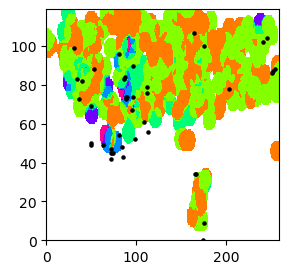

248
2014-01-26 13:55:43+00:00


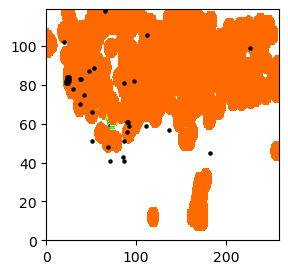

252
2014-02-03 03:08:46+00:00


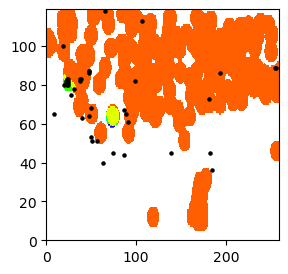

172
2014-05-24 09:25:03+00:00


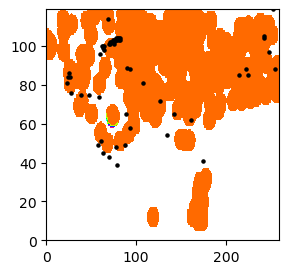

199
2014-08-29 03:45:04+00:00


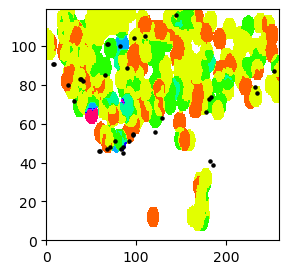

235
2015-04-16 18:07:43+00:00


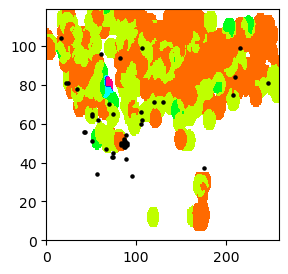

260
2015-11-17 07:10:07+00:00


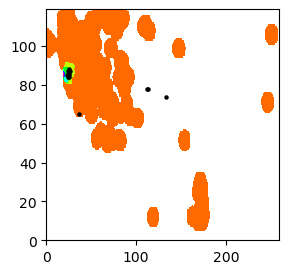

135
2017-06-12 12:28:39+00:00


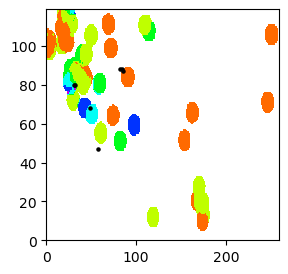

73
2017-07-20 22:31:11+00:00


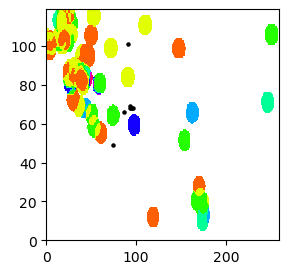

81
2018-10-25 22:54:52+00:00


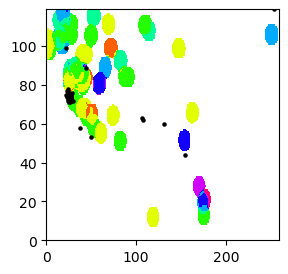

83
2019-08-08 11:25:31+00:00


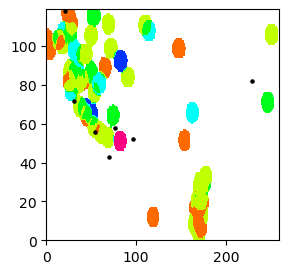

73
2019-11-26 02:54:12+00:00


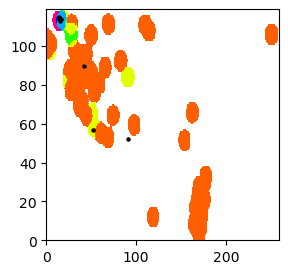

70
2019-11-27 07:23:42+00:00


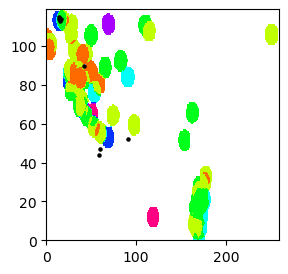

70
2020-01-24 17:55:13+00:00


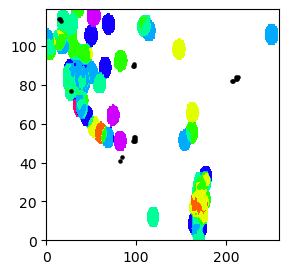

87
2020-01-30 11:21:37+00:00


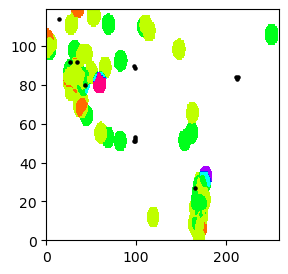

80
2020-05-02 12:51:06+00:00


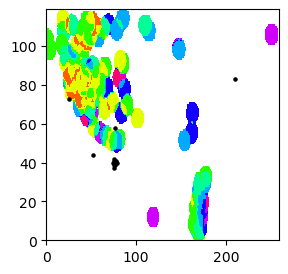

130
2020-05-18 23:22:35+00:00


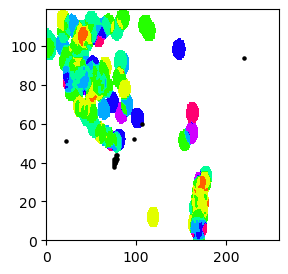

130
2020-06-14 14:24:29+00:00


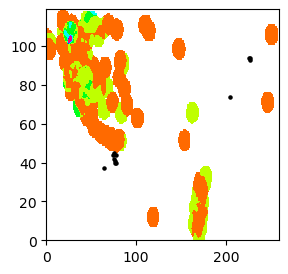

133
2020-09-18 16:28:17+00:00


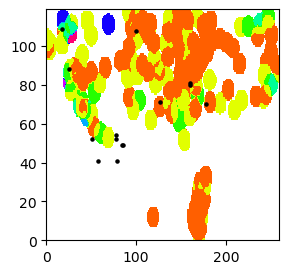

171
2020-10-30 11:51:27+00:00


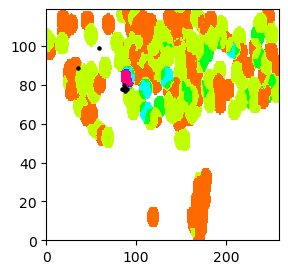

193
2021-03-03 10:16:09+00:00


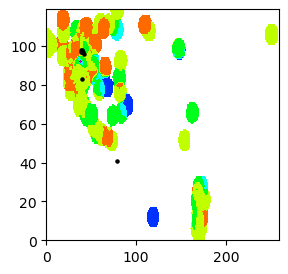

104
2021-03-04 18:38:19+00:00


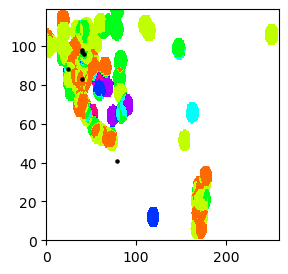

105
2021-09-27 06:17:22+00:00


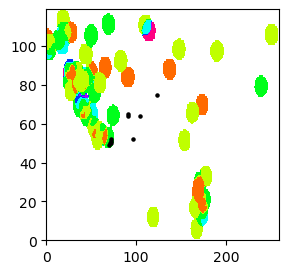

68
2021-10-12 09:24:03+00:00


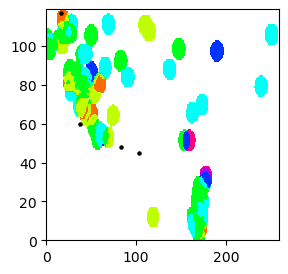

84
2021-10-19 05:32:32+00:00


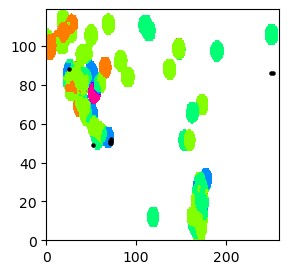

83
2022-01-11 01:07:48+00:00


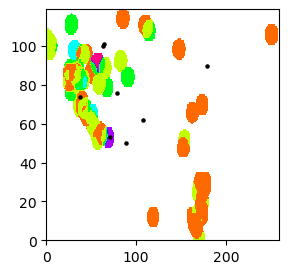

69
2022-11-23 01:08:15+00:00


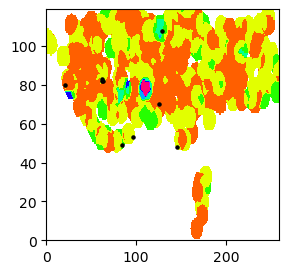

241
2023-01-25 12:37:05+00:00


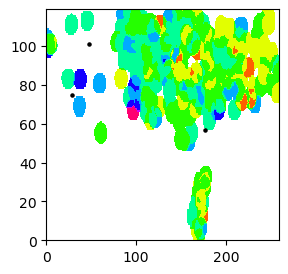

169
2023-02-06 01:17:34+00:00


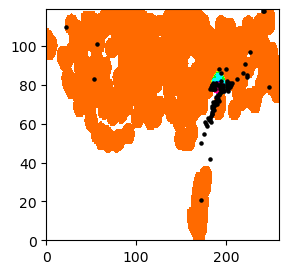

241
2023-02-06 01:28:15+00:00


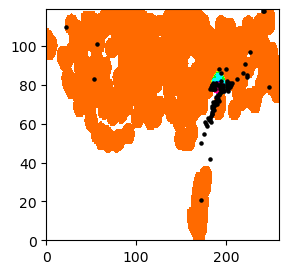

241
2023-02-06 10:24:49+00:00


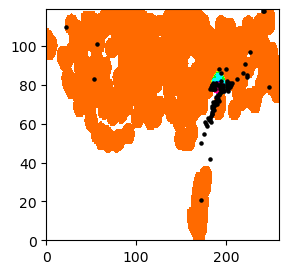

241
2023-02-06 10:26:48+00:00


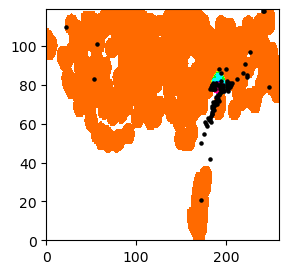

241
2023-02-06 10:35:58+00:00


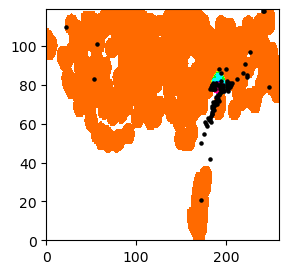

241
2023-02-06 12:02:11+00:00


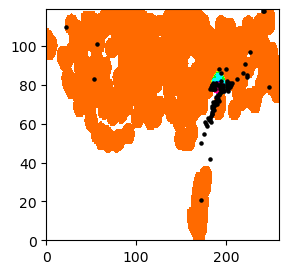

241
2023-02-20 17:04:29+00:00


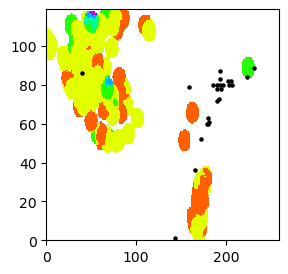

112
california
2012-12-14 10:36:01+00:00


In [91]:
maximal_time_shift = np.timedelta64(7, 'D')
minimal_time_shift = np.timedelta64(1, 'D')
dlat = 0.1
dlon = 0.1
datasets = {}
for name, catalog in catalogs.items():
    dataset = []
    print(name)
    # discretization of the region
    region = regions[name]
    N_lat = int((region[1]-region[0])/dlat)
    N_lon = int((region[3]-region[2])/dlon)
    grid_latlat, grid_lonlon = np.meshgrid( region[0] + np.arange(0, N_lat)*dlat, region[2] + np.arange(0, N_lon)*dlon, indexing='ij')
    grid_latlat = grid_latlat.flatten()
    grid_lonlon = grid_lonlon.flatten()
    grid = np.hstack([grid_latlat[:,None], grid_lonlon[:,None]])
    stations_coords = np.hstack([station_info[name][1][:,None], station_info[name][2][:,None]])
    grid_stations_dists = haversine_distances(np.radians(grid), np.radians(stations_coords))
    grid_stations_dists = grid_stations_dists.reshape((N_lat, N_lon, -1))
    

    # earthquakes identification
    large_shocks = catalog[catalog.Magnitude >= 5.8]
    large_shocks_days = large_shocks.Time
    large_shocks_coords =  large_shocks[['Latitude','Longitude']].values
    for day_time, coord in zip(large_shocks_days, large_shocks_coords):
        print(day_time)
        day = np.datetime64(datetime.datetime(day_time.year, day_time.month, day_time.day))
        aftershocks = catalog[(catalog.Time.values.astype('datetime64[D]') >=  day + minimal_time_shift)*(catalog.Time.values.astype('datetime64[D]') <= pd.to_datetime(day) +maximal_time_shift ) ]
        aftershocks_coords = aftershocks[['Latitude','Longitude']].values
        aftershocks_map = construct_aftershocks_map(region, aftershocks_coords, dlat, dlon)
        # daily data
        data = []
        indices = []
        for cnt, (s_name, _,__) in  enumerate(zip(*station_info[name])):
            df = station_data[s_name]
            row = df[df.date==  day]
            row_p = df[df.date==  day - np.timedelta64(1, 'D')]
            if(len(row) > 0 and len(row_p) > 0):
                u_n = row.lat.values[0]-row_p.lat.values[0]
                u_e = row.lon.values[0]-row_p.lon.values[0]
                u_v = row.height.values[0] - row_p.height.values[0]
                data.append((u_n, u_e, u_v))
                indices.append(cnt)
        if(len(indices) > 0):
            data = np.array(data)
            indices = np.array(indices)
            
            u_map = construct_map(data, indices, grid_stations_dists)
            dataset.append((day_time, coord,u_map, aftershocks_map))
            #print(data)
            fig, ax = plt.subplots(ncols=1, figsize=(3,3))
            ax.contourf(np.sqrt(u_map[:,:,0]**2+u_map[:,:,1]**2), cmap='hsv')
            locs = np.argwhere(aftershocks_map>0)
            #ax[0].contour(aftershocks_map, cmap='Greys', levels=2)
            ax.scatter(locs[:,1], locs[:,0], color='black', s=5)
            plt.show()
            print(len(indices))
    datasets[name] = dataset

In [89]:
study_name = "japan"
dataset = datasets[study_name]
x_train = []
x_test = []
y_train = []
y_test = []
limit_date = datetime.datetime(2020,1,1,0,0,0, tzinfo=datetime.timezone.utc)
for data in dataset:
    if(data[0]  > limit_date):
        y_test.append(data[3])
        x_test.append(data[2])
    else:
        y_train.append(data[3])
        x_train.append(data[2])
y_train = np.array(y_train)
y_test = np.array(y_test)
x_train = np.array(x_train)
x_test = np.array(x_test)